## Data

In [1]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import spacy
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read data 
# since we are in \models we have to change the working dir 
import os
os.chdir("..") # RUN THIS ONLY ONCE

In [28]:
file_path = 'Datasets\\Hydra-Movie-Scrape.csv'
movies_data = pd.read_csv(file_path)
movies_data.head(1)

,Title,Year,Summary,Short Summary,Genres,IMDB ID,Runtime,YouTube Trailer,Rating,Movie Poster,Director,Writers,Cast
0,Patton Oswalt: Annihilation,2017,"Patton Oswald, despite a personal tragedy, pro...","Patton Oswalt, despite a personal tragedy, pro...",Uncategorized,tt7026230,66,4hZi5QaMBFc,7.4,https://hydramovies.com/wp-content/uploads/201...,Bobcat Goldthwait,Patton Oswalt,Patton Oswalt


## Data Preprocessing

In [29]:
# preprocessing data / removing nulls
missing_values = movies_data.isnull().sum()
# print(missing_values)
movies_data_cleaned = movies_data.dropna(subset=['Summary']).copy()
movies_data_cleaned.drop(columns=['Movie Poster', 'IMDB ID', 'Short Summary'], inplace=True)

In [30]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

def lemmatize_(text):
    lemmatizer = WordNetLemmatizer()
    # return ' '.join([word for word in text.split() if len(word) >= 3])
    stop_words = set(stopwords.words("english"))
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])

In [31]:
movies_data_cleaned['Summary'] = movies_data_cleaned['Summary'].str.replace('[^\w\s]', '', regex=True)
movies_data_cleaned['Summary'] = movies_data_cleaned['Summary'].str.lower()
movies_data_cleaned['Summary'] = movies_data_cleaned['Summary'].apply(lemmatize_)

<>:1: SyntaxWarning: invalid escape sequence '\w'
<>:1: SyntaxWarning: invalid escape sequence '\w'
C:\Users\mumle\AppData\Local\Temp\ipykernel_22488\179091786.py:1: SyntaxWarning: invalid escape sequence '\w'
  movies_data_cleaned['Summary'] = movies_data_cleaned['Summary'].str.replace('[^\w\s]', '', regex=True)


Padding sequences so that they are all the same length

In [32]:
pad_chars = lambda s: s[:400] if len(s) > 400 else s + (' ' * (400 - len(s)))
movies_data_cleaned['Summary'] = movies_data_cleaned['Summary'].apply(pad_chars) 

In [33]:
movies_data_cleaned['Summary'].apply(len)

0       400
1       400
2       400
3       400
4       400
       ... 
3935    400
3936    400
3937    400
3938    400
3939    400
Name: Summary, Length: 3935, dtype: int64

In [34]:
# if there are multiple genres then seperating the next genres into a different column 
genres_split = movies_data_cleaned['Genres'].str.split('|', expand=True)
for i in range(genres_split.shape[1]):
    movies_data_cleaned[f'Genre_{i+1}'] = genres_split[i]
for col in movies_data_cleaned.columns:
    if 'Genre_' in col:
        movies_data_cleaned[col] = movies_data_cleaned[col].str.lower().str.strip()

movies_data_cleaned.drop(columns=['Genres'], inplace=True)
movies_data_cleaned.head(1)

,Title,Year,Summary,Runtime,YouTube Trailer,Rating,Director,Writers,Cast,Genre_1,Genre_2,Genre_3,Genre_4,Genre_5
0,Patton Oswalt: Annihilation,2017,patton oswald despite personal tragedy produce...,66,4hZi5QaMBFc,7.4,Bobcat Goldthwait,Patton Oswalt,Patton Oswalt,uncategorized,None,None,None,None


In [35]:
# split cast into different 
cast_split = movies_data_cleaned['Cast'].str.split('|', expand=True)
for i in range(cast_split.shape[1]):
    movies_data_cleaned[f'Cast_{i+1}'] = cast_split[i]
for col in movies_data_cleaned.columns:
    if 'Cast_' in col:
        movies_data_cleaned[col] = movies_data_cleaned[col].str.lower().str.strip()

movies_data_cleaned.drop(columns=['Cast'], inplace=True)
movies_data_cleaned.head(1)

,Title,Year,Summary,Runtime,YouTube Trailer,Rating,Director,Writers,Genre_1,Genre_2,Genre_3,Genre_4,Genre_5,Cast_1,Cast_2,Cast_3
0,Patton Oswalt: Annihilation,2017,patton oswald despite personal tragedy produce...,66,4hZi5QaMBFc,7.4,Bobcat Goldthwait,Patton Oswalt,uncategorized,None,None,None,None,patton oswalt,None,None


In [36]:
bool_title = movies_data_cleaned['Title'] == "Finding Dory"
movies_data_cleaned[bool_title]['Summary'].item()

'dory wideeyed blue tang fish suffers memory loss every 10 second one thing remember somehow became separated parent child help friend nemo marlin dory embarks epic adventure find journey brings marine life institute conservatory house diverse ocean specie                                                                                                                                                 '

In [37]:
bool_title = movies_data_cleaned['Title'] == "Finding Nemo"
movies_data_cleaned[bool_title]['Summary'].item()

'clown fish named marlin life great barrier reef loses son nemo venture open sea despite father constant warning many ocean danger nemo abducted boat netted sent dentist office sydney marlin venture try retrieve nemo marlin meet fish named dory blue tang suffering shortterm memory loss companion travel great distance encountering various dangerous sea creature shark anglerfish jellyfish order rescu'

## TF-IDF Embedding
tf-idf allows us to convert the word input to a numerical input. The embedding records the relative importance/frequency of each word to the corpus; 

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(min_df=3, max_features=None, 
                                   strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
                                   ngram_range=(1, 3), use_idf=True, smooth_idf=True, sublinear_tf=True,
                                   stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(movies_data_cleaned['Summary'])

## Pulling out important keywords for each film

In [39]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)
tfidf_matrix = tfidf_vectorizer.fit_transform(movies_data_cleaned['Summary'])
feature_names = tfidf_vectorizer.get_feature_names_out()

def get_top_n_keywords(row, top_n=25):
    sorted_indices = np.argsort(row.toarray()).flatten()[::-1]
    top_n_indices = sorted_indices[:top_n]
    top_n_keywords = [feature_names[i] for i in top_n_indices]
    return top_n_keywords

movies_data_cleaned['Keywords'] = [get_top_n_keywords(row, top_n=5) for row in tfidf_matrix]

movies_data_cleaned[['Summary', 'Keywords']].head()

,Summary,Keywords
0,patton oswald despite personal tragedy produce...,"[patton, oswald, tribulation, focusing, produce]"
1,recovering alcoholic recently converted mormon...,"[band, reuniting, mormon, converted, kane]"
2,everyone snowed house mouse mickey suggests th...,"[christmas, disney, mickey, everyone, show]"
3,villain popular animated disney film gathered ...,"[mickey, mouse, villain, house, gathered]"
4,cruel world junior high edwin suffers state an...,"[alienation, misunderstood, unflinching, anxie..."


In [40]:
movies_data_cleaned['Keywords_str'] = movies_data_cleaned['Keywords'].apply(lambda x: ' '.join(x))

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer_keywords = TfidfVectorizer()
tfidf_matrix_keywords = tfidf_vectorizer_keywords.fit_transform(movies_data_cleaned['Keywords_str'])
print("TF-IDF Matrix Keywords shape:", tfidf_matrix_keywords.shape)

TF-IDF Matrix Keywords shape: (3935, 8750)


## Preparation for model training

We are creating a one-hot-encoding for each genre and cast member for this model. 

In [42]:
genre1_dummies = pd.get_dummies(movies_data_cleaned['Genre_1'])
genre2_dummies = pd.get_dummies(movies_data_cleaned['Genre_2'])
genre3_dummies = pd.get_dummies(movies_data_cleaned['Genre_3'])
genre4_dummies = pd.get_dummies(movies_data_cleaned['Genre_4'])
genre5_dummies = pd.get_dummies(movies_data_cleaned['Genre_5'])

In [43]:
director_dummies = pd.get_dummies(movies_data_cleaned['Director'])
print("Director Dummies shape:", director_dummies.shape)

Director Dummies shape: (3935, 2399)


In [44]:
writers_dummies = pd.get_dummies(movies_data_cleaned['Writers'])

In [45]:
cast1_dummies = pd.get_dummies(movies_data_cleaned['Cast_1'])
cast2_dummies = pd.get_dummies(movies_data_cleaned['Cast_2'])
cast3_dummies = pd.get_dummies(movies_data_cleaned['Cast_3'])

In [46]:
# stacking all of the encoded features together 
from scipy.sparse import hstack
combined_features = hstack([tfidf_matrix_keywords, director_dummies,
                            writers_dummies,cast1_dummies, cast2_dummies, cast3_dummies, 
                            genre1_dummies, genre2_dummies, genre3_dummies, genre4_dummies, genre5_dummies])

## Cosine Similarity 
we are using cosine similarity to create a vector difference between each movie, where the difference is calculated with the encoded features. Close vectors are assumed to be similar movies in plot/genre/cast, and far vectors are assumed to be very unalike. 

In [47]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(combined_features, combined_features)

Because the cosine similarity is found by dot product, it should be commutative. 

In [48]:
bool_title = movies_data_cleaned['Title'] == "Finding Nemo"
idx_nemo = movies_data_cleaned[bool_title].index.tolist()[0]
bool_title = movies_data_cleaned['Title'] == "Finding Dory"
idx_dory = movies_data_cleaned[bool_title].index.tolist()[0]

print(list(enumerate(cosine_sim[idx_dory]))[idx_nemo][1])
list(enumerate(cosine_sim[idx_nemo]))[idx_dory][1]

0.30000000000000004


0.30000000000000004

## Recommending "Alike" movies given a title

In [49]:
def recommend_movies(title, cosine_sim=cosine_sim, dissimilar=False):
    # getting the index of the given title in our cosine similarity model 
    bool_title = movies_data_cleaned['Title'] == title
    idx = movies_data_cleaned[bool_title].index.tolist()[0]
    sim_scores = list(enumerate(cosine_sim[idx]))

    # with this, we can find all of the nearby vectors, excludng the given title itself.
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=not dissimilar)
    sim_scores = sim_scores[0:11]
    print(sim_scores)
    movie_indices = [i[0] for i in sim_scores]
    return movies_data_cleaned['Title'][movie_indices]

In [50]:
recommendations = recommend_movies('Finding Dory')
recommendations

[(579, 0.9999999999999999), (2341, 0.9398226687863819), (606, 0.5270462766947299), (244, 0.5), (276, 0.5), (351, 0.5), (429, 0.5), (492, 0.5), (514, 0.5), (573, 0.5), (650, 0.5)]


579                                          Finding Dory
2341                                 Finding Vivian Maier
606                 Captain Sparky vs. The Flying Saucers
244     Phineas and Ferb the Movie: Across the 2nd Dim...
276                                The Lego Ninjago Movie
351                                       Despicable Me 3
429                                 The LEGO Batman Movie
492                                                 Moana
514                                                Trolls
573                               The Secret Life of Pets
650         Scooby-Doo! and WWE: Curse of the Speed Demon
Name: Title, dtype: object

In [51]:
recommendations = recommend_movies('New York Doll', dissimilar=True)
recommendations

[(0, 0.0), (2, 0.0), (3, 0.0), (4, 0.0), (5, 0.0), (6, 0.0), (7, 0.0), (8, 0.0), (9, 0.0), (11, 0.0), (13, 0.0)]


0                           Patton Oswalt: Annihilation
2     Mickey's Magical Christmas: Snowed in at the H...
3                            Mickey's House of Villains
4                                         And Then I Go
5                              An Extremely Goofy Movie
6                                          Peter Rabbit
7                                            Love Songs
8                                                    89
9                                        The Foster Boy
11                              Tom Segura: Disgraceful
13                                  Secrets in the Fall
Name: Title, dtype: object

#### Similar Movie Data Exploration

Shrek
1674


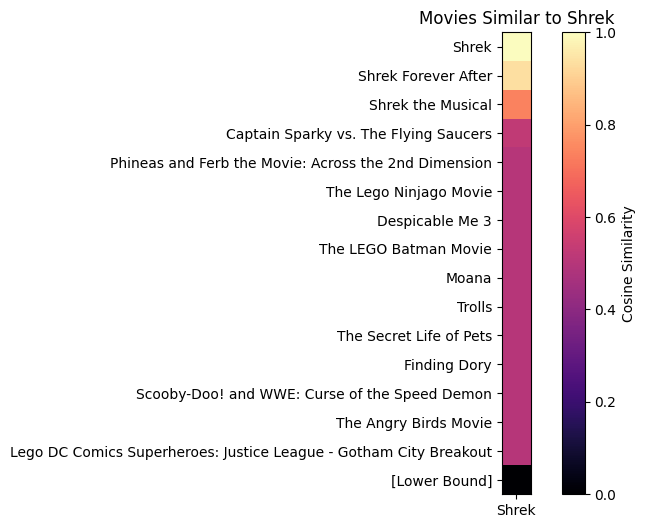

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Sample categorical data
# related movies
bool_title = movies_data_cleaned['Title'] == 'Shrek'
idx = movies_data_cleaned[bool_title].index.tolist()[0]
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[:15]
print(movies_data_cleaned['Title'][idx])
print(idx)
movie_indices = [i[0] for i in sim_scores]
labels = list(movies_data_cleaned['Title'][movie_indices])
labels.append("[Lower Bound]")
sim_scores.append((0,0))

# stuff cosine similarity into matrix 
x, y = zip(*sim_scores)
heat_arr = np.array([y]).transpose()

# Create the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(heat_arr, cmap='magma')

# Add labels for x-axis and y-axis
plt.yticks(np.arange(len(labels)), labels)
plt.xticks([0], ["Shrek"])

# Add a color bar
plt.colorbar(label='Cosine Similarity')

plt.title('Movies Similar to Shrek')
plt.show()

This makes sense because we would expect the similarity between Shrek, its sequels, and children's movies to be similar.

### Dissimilar Exploration

Shrek
1674


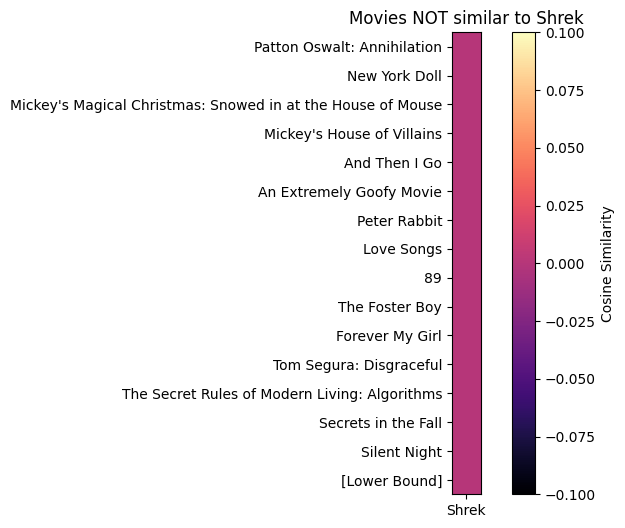

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Sample categorical data
# related movies
bool_title = movies_data_cleaned['Title'] == 'Shrek'
idx = movies_data_cleaned[bool_title].index.tolist()[0]
sim_scores = list(enumerate(cosine_sim[idx]))
np.random.shuffle(list(enumerate(cosine_sim[idx])))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=False)[:15]
print(movies_data_cleaned['Title'][idx])
print(idx)
movie_indices = [i[0] for i in sim_scores]
labels = list(movies_data_cleaned['Title'][movie_indices])
labels.append("[Lower Bound]")
sim_scores.append((0,0))

# stuff cosine similarity into matrix 
x, y = zip(*sim_scores)
heat_arr = np.array([y]).transpose()

# Create the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(heat_arr, cmap='magma')

# Add labels for x-axis and y-axis
plt.yticks(np.arange(len(labels)), labels)
plt.xticks([0], ["Shrek"])

# Add a color bar
plt.colorbar(label='Cosine Similarity')

plt.title('Movies NOT similar to Shrek')
plt.show()

### Free-Form input

In [54]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

In [55]:
tfidf_matrix_summaries = tfidf_vectorizer.fit_transform(movies_data_cleaned['Summary'])

In [56]:
def recommend_movies_based_on_input_plot(input_plot, tfidf_vectorizer=tfidf_vectorizer, tfidf_matrix=tfidf_matrix_summaries):
    input_vec = tfidf_vectorizer.transform([input_plot])
    cosine_sim = cosine_similarity(input_vec, tfidf_matrix)
    sim_scores = list(enumerate(cosine_sim[0]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return movies_data_cleaned['Title'].iloc[movie_indices]


In [57]:
input_plot = "A story about the adventures in a magical land far away."
recommended_movies = recommend_movies_based_on_input_plot(input_plot)
print(recommended_movies)

3003                                         Pan
1476    The Disappearance of Eleanor Rigby: Them
1199           Tinker Bell and the Lost Treasure
2085                                       K-PAX
1671                             Shrek the Third
1852                   Oz the Great and Powerful
698                                 Nanny McPhee
1478     The Disappearance of Eleanor Rigby: Her
1237                             The Water Horse
2545                                   Cast Away
Name: Title, dtype: object


This produces a pretty good result. Let's compare effects caused by change in keywords/ adjectives

In [58]:
input_plot = "Documentary that features cool investigative journalism"
recommended_movies = recommend_movies_based_on_input_plot(input_plot)
print(recommended_movies)

381                              The Case for Christ
1395                          The Inbetweeners Movie
1959                 Metallica: Some Kind of Monster
266     Chasing Trane: The John Coltrane Documentary
2931                                   Alien Outpost
1753                                  Righteous Kill
3904                                           Elles
2713                                    African Cats
233                                           Voyeur
2035                                       Leviathan
Name: Title, dtype: object


In [64]:
input_plot = "Documentary that features investigative journalism"
recommended_movies = recommend_movies_based_on_input_plot(input_plot)
print(recommended_movies)

381                              The Case for Christ
1959                 Metallica: Some Kind of Monster
266     Chasing Trane: The John Coltrane Documentary
2931                                   Alien Outpost
1753                                  Righteous Kill
3904                                           Elles
2713                                    African Cats
233                                           Voyeur
2035                                       Leviathan
1397                                    The Imposter
Name: Title, dtype: object


As you can see, the recommendation of "The Inbetweeners Movie" hinges solely on the word "cool"

In [65]:
def recommend_movie(input_plot, preferred_genre, tfidf_vectorizer=tfidf_vectorizer, tfidf_matrix=tfidf_matrix_summaries, movies_data=movies_data_cleaned):
    input_vec = tfidf_vectorizer.transform([input_plot])
    genre_columns = ['Genre_1', 'Genre_2', 'Genre_3', 'Genre_4', 'Genre_5'] 
    filtered_movies = movies_data[genre_columns].apply(lambda x: x.str.contains(preferred_genre, case=False, na=False)).any(axis=1)
    filtered_movies_data = movies_data[filtered_movies]
    if not filtered_movies_data.empty:
        filtered_tfidf_matrix = tfidf_matrix[filtered_movies_data.index]
        cosine_sim = cosine_similarity(input_vec, filtered_tfidf_matrix)
        best_match_idx = cosine_sim.argmax()
        recommended_movie_title = filtered_movies_data.iloc[best_match_idx]['Title']
        return recommended_movie_title
    else:
        return "No movies found in the preferred genre."
input_plot = "A young woman's journey through love and heartbreak."
preferred_genre = "Romance"
recommended_movie = recommend_movie(input_plot, preferred_genre)
print(f"Recommended Movie: {recommended_movie}")


Recommended Movie: Slumdog Millionaire


In [66]:
def recommend_movie(tfidf_vectorizer=tfidf_vectorizer, tfidf_matrix=tfidf_matrix_summaries, movies_data=movies_data_cleaned):
    input_plot = input("Enter a plot summary: ")
    input_vec = tfidf_vectorizer.transform([input_plot])
    preferred_genre = input("Enter your preferred genre: ")
    genre_columns = ['Genre_1', 'Genre_2', 'Genre_3', 'Genre_4', 'Genre_5']
    filtered_movies = movies_data[genre_columns].apply(lambda x: x.str.contains(preferred_genre, case=False, na=False)).any(axis=1)
    filtered_movies_data = movies_data[filtered_movies]
    if not filtered_movies_data.empty:
        filtered_tfidf_matrix = tfidf_matrix[filtered_movies_data.index]
        cosine_sim = cosine_similarity(input_vec, filtered_tfidf_matrix)
        best_match_idx = cosine_sim.argmax()
        recommended_movie_title = filtered_movies_data.iloc[best_match_idx]['Title']
        return recommended_movie_title
    else:
        return "No movies found in the preferred genre."

# Run the recommendation function and print the recommended movie
recommended_movie = recommend_movie()
print(f"Recommended Movie: {recommended_movie}")


Enter a plot summary:  hello
Enter your preferred genre:  s


IndexError: index (3939) out of range

In [62]:
# saving model 
import joblib
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.joblib')
np.save('cosine_similarity.npy', cosine_sim)
np.save('tfidf_matrix_summaries.npy', tfidf_matrix_summaries)
movies_data_cleaned.to_csv('movies_data_cleaned.csv', index=False)